In [4]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# --- Load Temperature Data from NetCDF ---
temp_ds = xr.open_dataset("C:/Users/VINCENT/Desktop/CAN/Calabar_data.nc")

In [7]:
# Display variable names and coordinates
temp_ds

<xarray.Dataset>
Dimensions:     (valid_time: 720, latitude: 5, longitude: 5)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2025-04-01 ... 2025-04-30T23:00:00
  * latitude    (latitude) float64 5.5 5.25 5.0 4.75 4.5
  * longitude   (longitude) float64 8.0 8.25 8.5 8.75 9.0
    expver      (valid_time) object ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-11T04:38 GRIB to CDM+CF via cfgrib-0.9.1...

In [8]:
# Step 1: Define bounding box for 1x1 degree around Calabar
lat_bounds = [4.5, 5.5]
lon_bounds = [7.5, 8.5]

In [10]:
# Step 2: Select the region from the dataset
subset = temp_ds.sel(latitude=slice(*lat_bounds[::-1]), longitude=slice(*lon_bounds))

In [48]:
# Step 3: Convert time to datetime format
subset['datetime'] = pd.to_datetime(subset['valid_time'].values)

In [49]:
# Step 4: Filter data for the last 30 days
last_30_days = pd.Timestamp.now() - pd.Timedelta(days=30)
subset_recent = subset.sel(time=slice(last_30_days, None))

In [50]:
# Step 5: Calculate average temperature over time and space
avg_temp = subset_recent['t2m'].mean(dim=['latitude', 'longitude', 'valid_time'])

In [51]:
# Convert from Kelvin to Celsius
avg_temp_celsius = avg_temp - 273.15

print("Average temperature (°C) in the last month:", float(avg_temp_celsius.values))

Average temperature (°C) in the last month: 27.471246337890648


In [38]:
# Load the air quality CSV data
air_quality_df = pd.read_csv("C:/Users/VINCENT/Desktop/CAN/openaq_location_1894640_measurments.csv")

In [39]:
# Preview air quality data
air_quality_df.head()

,location_id,location_name,parameter,value,unit,datetimeUtc,datetimeLocal,timezone,latitude,longitude,country_iso,isMobile,isMonitor,owner_name,provider
0,1894640,Calabar,pm25,9.57,µg/m³,2025-04-01T03:04:54Z,2025-04-01T04:04:54+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity
1,1894640,Calabar,pm25,9.09,µg/m³,2025-04-01T03:22:19Z,2025-04-01T04:22:19+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity
2,1894640,Calabar,pm25,8.61,µg/m³,2025-04-01T03:39:44Z,2025-04-01T04:39:44+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity
3,1894640,Calabar,pm25,9.30,µg/m³,2025-04-01T03:57:10Z,2025-04-01T04:57:10+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity
4,1894640,Calabar,pm25,11.89,µg/m³,2025-04-01T04:14:35Z,2025-04-01T05:14:35+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity


In [44]:
air_quality_df['datetime'] = pd.to_datetime(air_quality_df['datetimeUtc'])
air_quality_df.set_index('datetime', inplace=True)

In [45]:
# Step 2: Resample to hourly mean values
pm25_hourly = air_quality_df[air_quality_df['parameter'] == 'pm25']['value'].resample('1h').mean()
pm25_hourly = pm25_hourly.reset_index().rename(columns={'value': 'pm25'})

In [46]:
# Step 3: Merge with temperatu# Step 2: Resample to hourly mean values
pm25_hourly['datetime'] = pm25_hourly['datetime'].dt.tz_localize(None)


In [52]:
# Merge the datasets again on datetime
# Extract average temperature over the 5x5 grid
# Compute the spatial mean (over lat and lon) for each time step
# Convert to pandas DataFrame
t2m_mean = temp_ds['t2m'].mean(dim=['latitude', 'longitude'])
t2m_df = t2m_mean.to_dataframe().reset_index()
t2m_df.rename(columns={'valid_time': 'datetime', 't2m': 'temperature_2m'}, inplace=True)
merged_df = pd.merge(t2m_df, pm25_hourly, on='datetime', how='inner')

In [53]:
# Drop NaNs to ensure clean covariance calculation
merged_df_clean = merged_df.dropna(subset=['temperature_2m', 'pm25'])


In [54]:
# Calculate covariance matrix
covariance_matrix = merged_df_clean[['temperature_2m', 'pm25']].cov()
covariance_matrix


,temperature_2m,pm25
temperature_2m,5.867971,-5.081900
pm25,-5.081900,59.572124


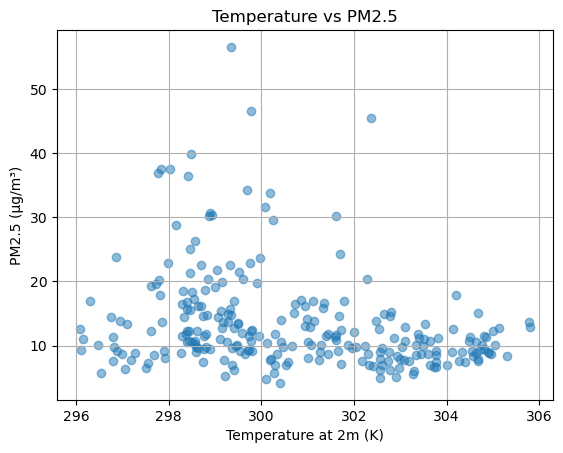

In [55]:
plt.scatter(merged_df_clean['temperature_2m'], merged_df_clean['pm25'], alpha=0.5)
plt.title('Temperature vs PM2.5')
plt.xlabel('Temperature at 2m (K)')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.show()

C:\Users\VINCENT\AppData\Local\Temp\ipykernel_13892\1155844364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean['temperature_celsius'] = merged_df_clean['temperature_2m'] - 273.15


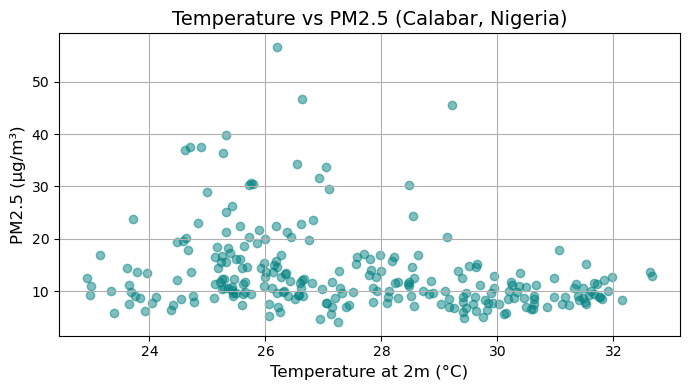

In [57]:
# Convert temperature from Kelvin to Celsius
merged_df_clean['temperature_celsius'] = merged_df_clean['temperature_2m'] - 273.15

# Create scatter plot
plt.figure(figsize=(7, 4))
plt.scatter(merged_df_clean['temperature_celsius'], merged_df_clean['pm25'], alpha=0.5, color='teal')
plt.title('Temperature vs PM2.5 (Calabar, Nigeria)', fontsize=14)
plt.xlabel('Temperature at 2m (°C)', fontsize=12)
plt.ylabel('PM2.5 (µg/m³)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()